In [1]:
import pickle
import os
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import FastICA
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
import nibabel as nib
import ants
from scipy.ndimage.morphology import binary_erosion
from scipy.ndimage.morphology import binary_dilation
import cv2
import bigbadbrain as bbb
import scipy
from scipy.interpolate import interp1d
from matplotlib.colors import ListedColormap
from matplotlib.pyplot import cm
import tqdm
import ffmpeg
from scipy.ndimage.filters import gaussian_filter1d
import matplotlib
import itertools
from matplotlib.colors import LogNorm
from scipy.spatial.transform import Rotation as R

/home/users/brezovec/.local/lib/python3.6/site-packages/ants/viz/render_surface_function.py:16: UserWarning: Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function
  "Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function"


In [2]:
fly_names = ['fly_087', 'fly_089', 'fly_094', 'fly_097', 'fly_098', 'fly_099', 'fly_100', 'fly_101', 'fly_105']
dataset_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset"

behaviors = ['dRotLabY', 'dRotLabZ', 'dRotLabX']; shorts = ['Y', 'Z', 'X']

fictrac = {'Y': [], 'Z': [], 'X': []}

for fly in fly_names:
    fly_dir = os.path.join(dataset_path, fly)
    fictrac_raw = bbb.load_fictrac(os.path.join(fly_dir, 'func_0', 'fictrac'))
    for behavior, short in zip(behaviors, shorts):
        fictrac[short].append(fictrac_raw[behavior])

for short in shorts:    
    fictrac[short] = np.asarray(fictrac[short])


~~ load_fictrac ~~
load_fictrac done. Duration: 3.45 sec

~~ load_fictrac ~~
load_fictrac done. Duration: 3.42 sec

~~ load_fictrac ~~
load_fictrac done. Duration: 3.43 sec

~~ load_fictrac ~~
load_fictrac done. Duration: 3.44 sec

~~ load_fictrac ~~
load_fictrac done. Duration: 3.41 sec

~~ load_fictrac ~~
load_fictrac done. Duration: 3.47 sec

~~ load_fictrac ~~
load_fictrac done. Duration: 3.38 sec

~~ load_fictrac ~~
load_fictrac done. Duration: 3.41 sec

~~ load_fictrac ~~
load_fictrac done. Duration: 3.39 sec


(-0.2, 0.2)

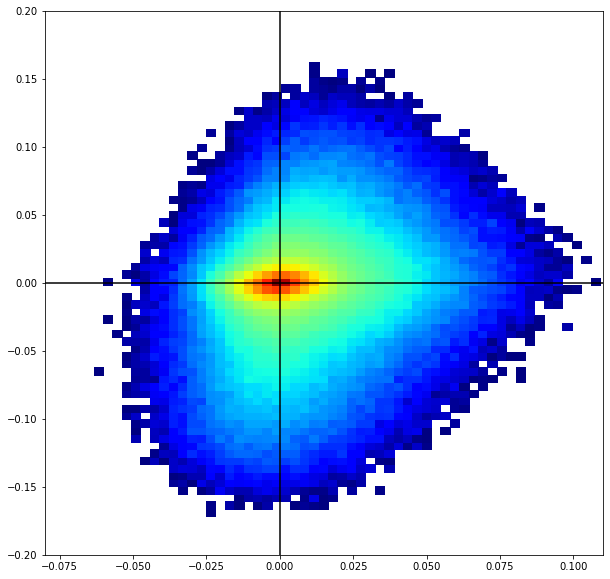

In [3]:
plt.figure(figsize=(10,10))
plt.hist2d(fictrac['Y'].flatten(), fictrac['Z'].flatten(),bins=100,norm=LogNorm(),cmin=10,cmap='jet');
plt.axvline(0,color='k')
plt.axhline(0,color='k')
plt.xlim(-.08,.11)
plt.ylim(-.2,.2)

In [69]:
def format_plot(xl,yl):
    plt.axvline(0,color='k')
    plt.axhline(0,color='k')
    #plt.xlim(-.08,.11)
    plt.xlim(-.2,.2)
    plt.ylim(-.2,.2)
    plt.ylabel(yl,fontsize=20)
    plt.xlabel(xl,fontsize=20)
    
def triple_hist_plot(data):
    plt.figure(figsize=(20,7))
    plt.subplot(1,3,1)
    plt.hist2d(data[1,:], data[2,:],bins=100,norm=LogNorm(),cmap='jet');
    format_plot('Y','Z')
    plt.subplot(1,3,2)
    plt.hist2d(data[1,:], data[0,:],bins=100,norm=LogNorm(),cmap='jet');
    format_plot('Y','X')
    plt.subplot(1,3,3)
    plt.hist2d(data[0,:], data[2,:],bins=100,norm=LogNorm(),cmap='jet');
    format_plot('X','Z')

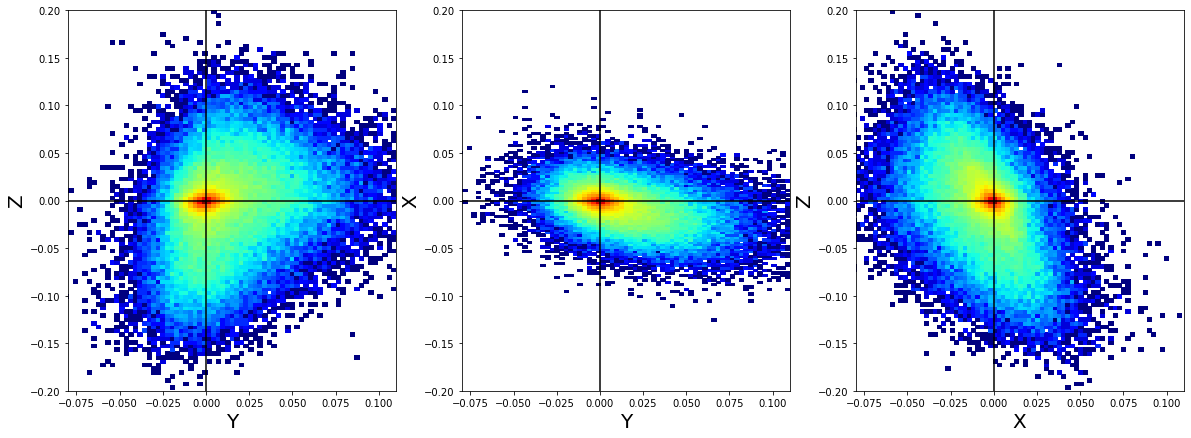

In [101]:
fly = 0
data = np.vstack((fictrac['X'][fly,:], fictrac['Y'][fly,:], fictrac['Z'][fly,:]))
triple_hist_plot(data)

In [118]:
from scipy.stats import skew

In [123]:
skew(fictrac['Y'][fly,:])

1.3314941151774506

(array([3.0000e+00, 5.3000e+01, 7.9300e+02, 1.6956e+04, 5.2241e+04,
        1.3599e+04, 4.8330e+03, 1.2520e+03, 2.2400e+02, 4.6000e+01]),
 array([-0.11158313, -0.08487344, -0.05816375, -0.03145406, -0.00474437,
         0.02196533,  0.04867502,  0.07538471,  0.1020944 ,  0.12880409,
         0.15551378]),
 <a list of 10 Patch objects>)

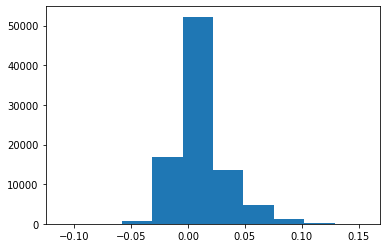

In [124]:
plt.hist(fictrac['Y'][fly,:])

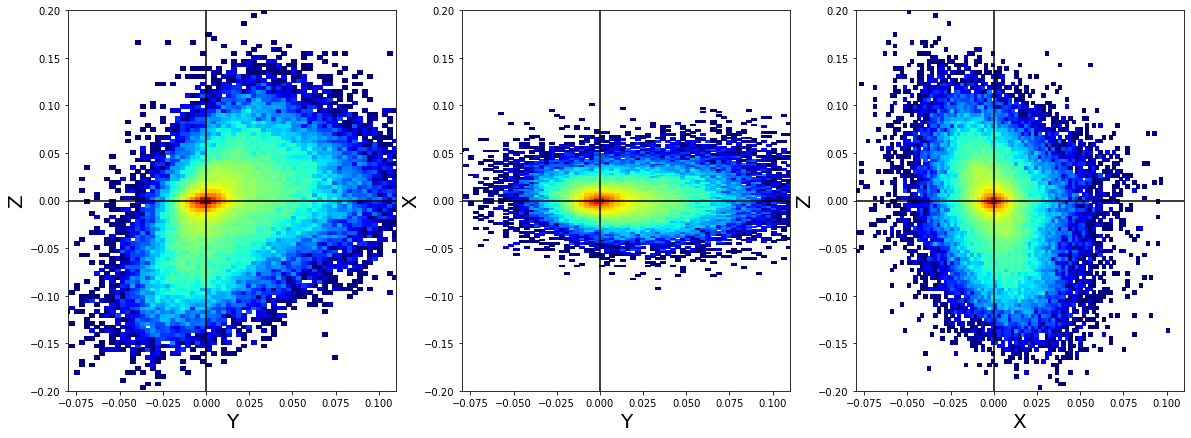

In [106]:
rotation_matrix = R.from_euler('z', 30, degrees=True).as_dcm()
data_r = np.matmul(data.T,rotation_matrix).T
triple_hist_plot(data_r)

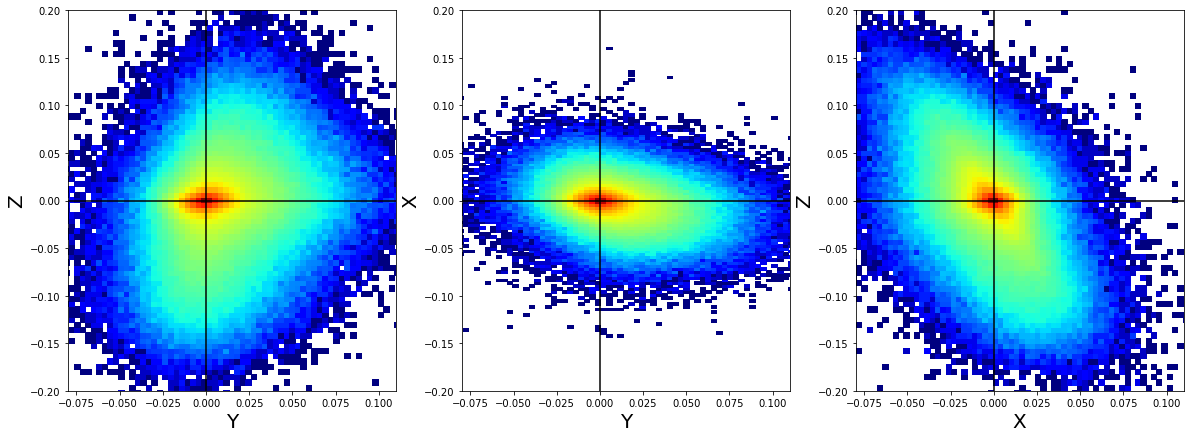

In [46]:
triple_hist_plot(data)

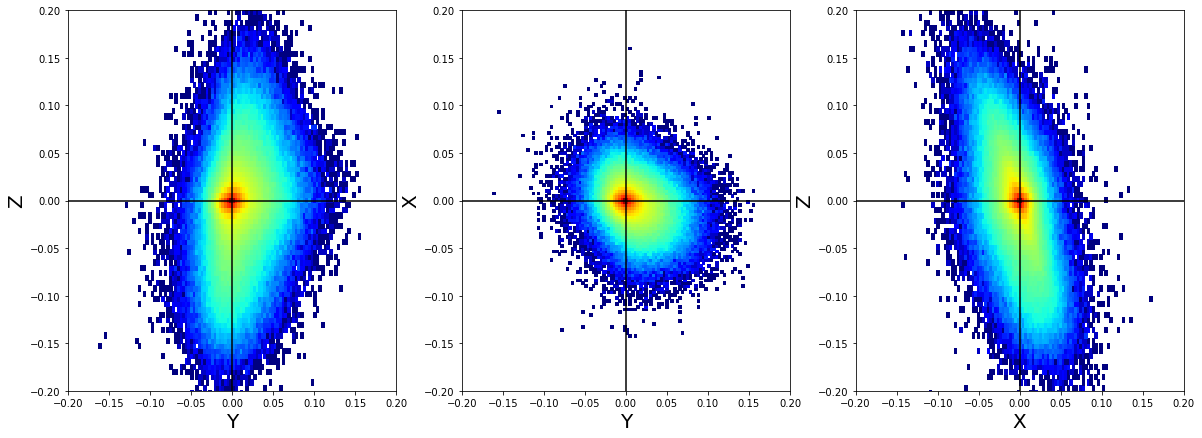

In [76]:
data = np.reshape(np.stack((fictrac['X'], fictrac['Y'], fictrac['Z'])),(3,-1))
rotation_matrix = R.from_euler('z', 0, degrees=True).as_dcm()
data_r = np.matmul(data.T,rotation_matrix).T
triple_hist_plot(data_r)

In [40]:
from scipy.optimize import least_squares

In [ ]:
# this must compute the residuals
def f(weights, data):
    r = R.from_euler('xyz', weights, degrees=True).as_dcm()
    data_r = np.matmul(data.T,r).T
    #X_skew = skew(data_r[0,:])
    #Z_shew = skew(data_r[2,:])
    X_skew = np.sum(data_r[0,:]>0)-np.sum(data_r[0,:]<0)
    Z_skew = np.sum(data_r[2,:]>0)-np.sum(data_r[2,:]<0)
    residual = (X_skew**2 + X_skew**2)**0.5
    return residual
    
weights = np.asarray([0,0,0])
res = least_squares(f, weights, args=([data]),verbose=1)
optimized_rotations = res.x

In [164]:
# this must compute the residuals
# def f(weights, data):
#     r = R.from_euler('xyz', weights, degrees=True).as_dcm()
#     data_r = np.matmul(data.T,r).T
#     X_skew = skew(data_r[0,:])
#     Z_skew = skew(data_r[2,:])
#     residual = (X_skew**2 + Z_skew**2)**0.5
#     return residual

def f(weights, data):
    r = R.from_euler('xyz', weights, degrees=True).as_dcm()
    data_r = np.matmul(data.T,r).T
    xy_corr, _ = scipy.stats.pearsonr(data_r[0,:], data_r[1,:])
    xz_corr, _ = scipy.stats.pearsonr(data_r[0,:], data_r[2,:])
    yz_corr, _ = scipy.stats.pearsonr(data_r[1,:], data_r[2,:])
    residual = (xy_corr**2 + xz_corr**2 + yz_corr**2)**0.5
    return residual


weights = np.asarray([0,0,0])
res = least_squares(f, weights, args=([data]),verbose=1)
optimized_rotations = res.x

`gtol` termination condition is satisfied.
Function evaluations 56, initial cost 2.0297e-01, final cost 1.0384e-13, first-order optimality 9.98e-09.


In [386]:
data = np.vstack((fictrac['X'][fly,:], fictrac['Y'][fly,:], fictrac['Z'][fly,:]))
data.shape

(3, 90000)

In [391]:
data = np.stack((fictrac['X'], fictrac['Y'], fictrac['Z']))
data = np.reshape(data, (3,-1))
data.shape

(3, 810000)

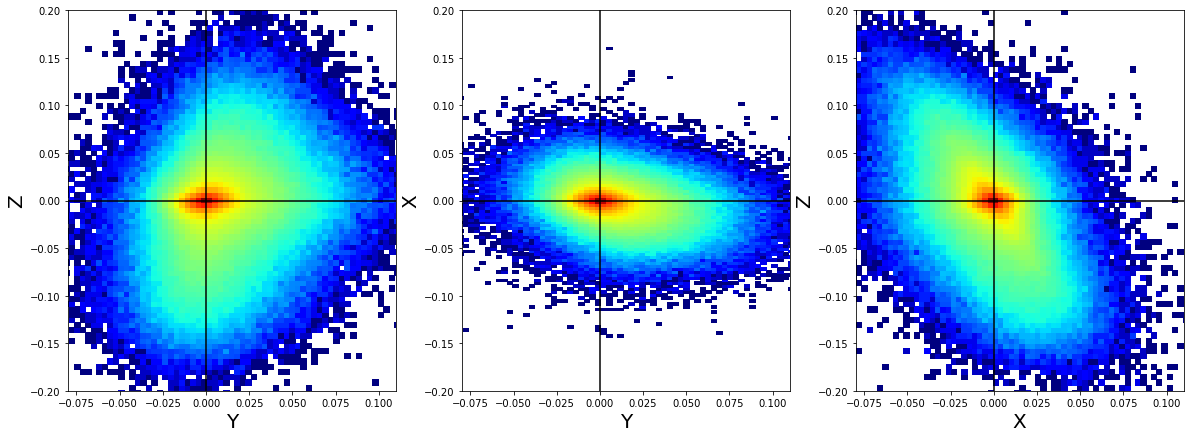

In [392]:
triple_hist_plot(data)

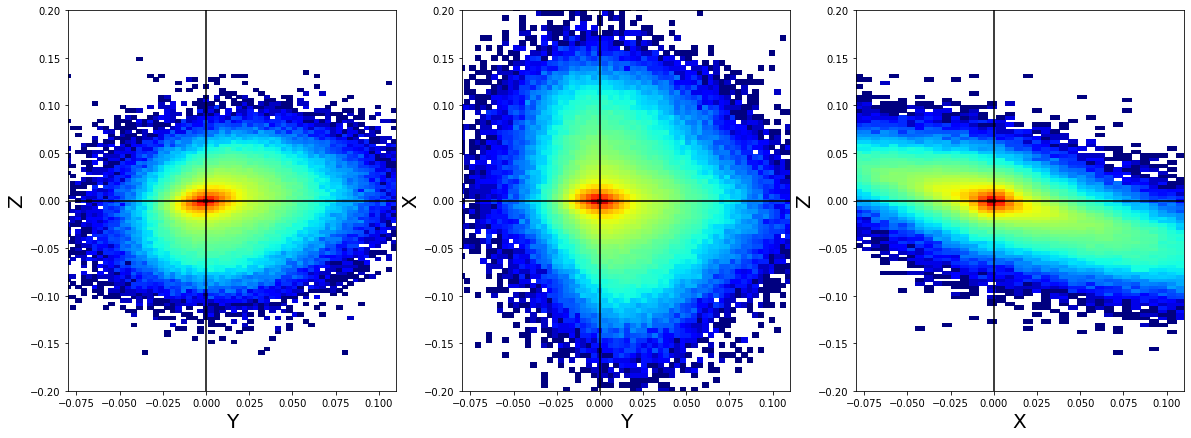

In [745]:
r = R.from_euler('xyz', [-10, 50, 10], degrees=True).as_dcm()
data_r = np.matmul(data.T,r).T
triple_hist_plot(data_r)

In [138]:
def optimize_and_plot(data):
    def f(weights, data):
        r = R.from_euler('xyz', weights, degrees=True).as_dcm()
        data_r = np.matmul(data.T,r).T
        
        xy_corr, _ = scipy.stats.pearsonr(data_r[0,:], data_r[1,:])
        xz_corr, _ = scipy.stats.pearsonr(data_r[0,:], data_r[2,:])
        yz_corr, _ = scipy.stats.pearsonr(data_r[1,:], data_r[2,:])
        #xz_corr += 1 #want this to be -1

        #residual = (xy_corr**2 + xz_corr**2 + yz_corr**2)**0.5
        residual = (xy_corr**2 + yz_corr**2 + xz_corr**2)**0.5

#         hist = np.log(np.histogram2d(data_r[1,:], data_r[2,:], bins=100)[0])
#         hist[hist==-inf]=0; hist[hist==inf]=0; hist[hist==np.nan]=0
#         residual = np.sum((hist[:,:50]-hist[:,-50:][:,::-1])**2)#**0.5
#         #print(residual)
#         residual = (residual + xy_corr**2 + xz_corr**2)**0.5
        
        return residual

    weights = np.asarray([0,0,0])
    res = least_squares(f, weights, args=([data]),verbose=1,diff_step=2,xtol=1e-40)
    optimized_rotations = res.x
    
    r = R.from_euler('xyz', optimized_rotations, degrees=True).as_dcm()
    data_r = np.matmul(data.T,r).T
    triple_hist_plot(data_r)
    return optimized_rotations, data_r

In [126]:
data = np.reshape(np.stack((fictrac['X'], fictrac['Y'], fictrac['Z'])),(3,-1))


`xtol` termination condition is satisfied.
Function evaluations 33, initial cost 1.8114e-01, final cost 1.7355e-02, first-order optimality 3.56e-03.
[ -6.46013698 -12.92761252   3.29629772]


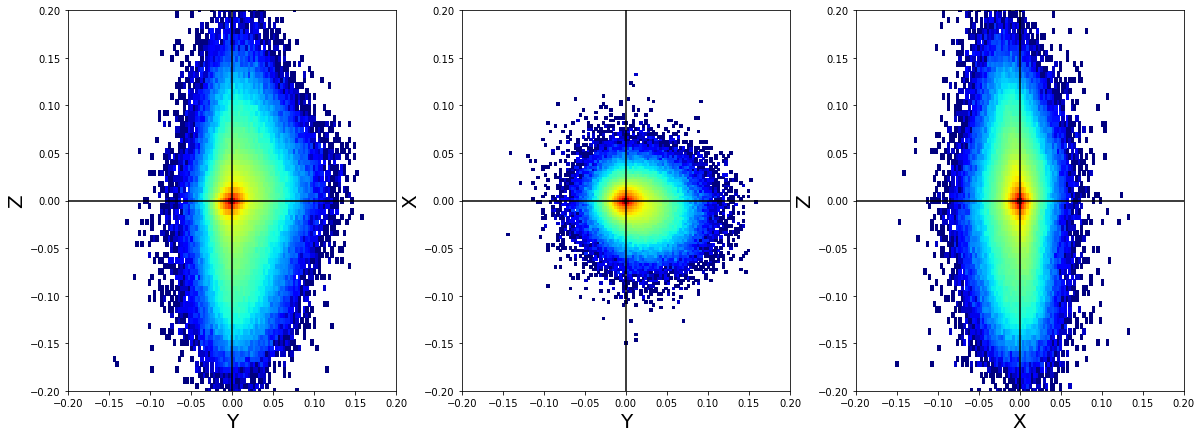

In [139]:
fly = 0
#data = np.vstack((fictrac['X'][fly,:], fictrac['Y'][fly,:], fictrac['Z'][fly,:]))
data = np.reshape(np.stack((fictrac['X'], fictrac['Y'], fictrac['Z'])),(3,-1))
weights, data_r = optimize_and_plot(data)
print(weights)

`xtol` termination condition is satisfied.
Function evaluations 33, initial cost 2.0297e-01, final cost 4.1477e-02, first-order optimality 4.51e-03.
[ -8.22634567 -10.10963749   6.31965401]


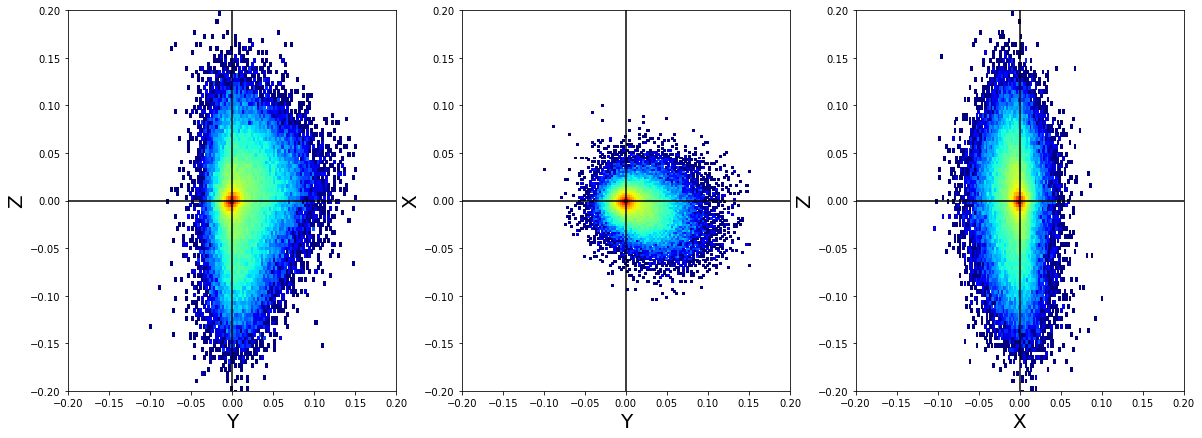

In [117]:
fly = 0
data = np.vstack((fictrac['X'][fly,:], fictrac['Y'][fly,:], fictrac['Z'][fly,:]))
#data = np.reshape(np.stack((fictrac['X'], fictrac['Y'], fictrac['Z'])),(3,-1))
weights, data_r = optimize_and_plot(data)
print(weights)

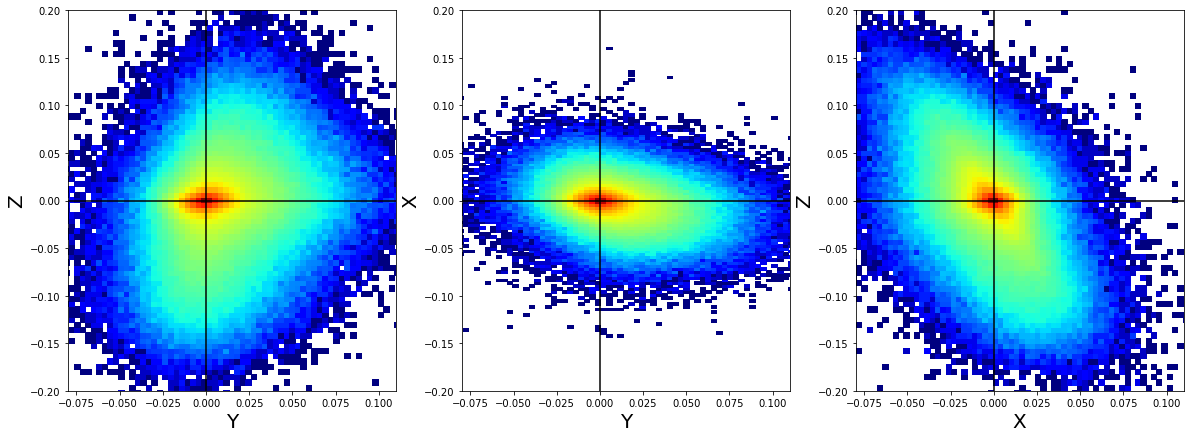

In [435]:
triple_hist_plot(data)

In [136]:
data = np.reshape(np.stack((fictrac['X'], fictrac['Y'], fictrac['Z'])),(3,-1))


r = R.from_euler('xyz', [ -6.46013698, -12.92761252,   3.29629772], degrees=True).as_dcm()
data_r = np.matmul(data.T,r).T

smoothedY = scipy.signal.savgol_filter(data_r[1,:],25,3)
smoothedZ = scipy.signal.savgol_filter(data_r[2,:],25,3)
Y_all_accel = np.append(np.diff(smoothedY), 0) #need to add a single value that was removed
Z_all_accel = np.append(np.diff(smoothedZ), 0) #need to add a single value that was removed

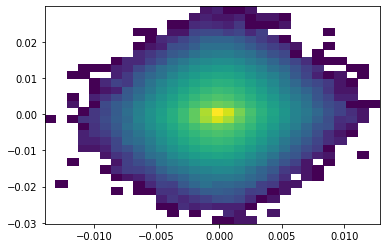

In [137]:
plt.hist2d(Y_all_accel,Z_all_accel,bins=30,norm = colors.LogNorm());

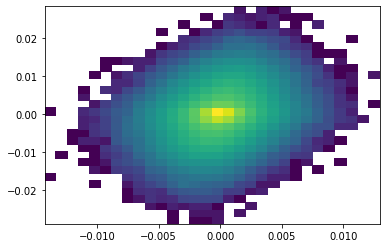

In [133]:
plt.hist2d(Y_all_accel,Z_all_accel,bins=30,norm = colors.LogNorm());

In [132]:
from matplotlib import colors

In [230]:
# fly = 7
#data = np.vstack((fictrac['X'][fly,:], fictrac['Y'][fly,:], fictrac['Z'][fly,:]))
data = np.reshape(np.stack((fictrac['X'], fictrac['Y'], fictrac['Z'])),(3,-1))
r = R.from_euler('xyz', [40,0,0], degrees=True).as_dcm()
data_r = np.matmul(data.T,r).T

In [231]:
smoothedY = scipy.signal.savgol_filter(data_r[1,:],25,3)
smoothedZ = scipy.signal.savgol_filter(data_r[2,:],25,3)

#Y_all_std = np.std(smoothedY)
#Z_all_std = np.std(smoothedZ)

In [232]:
 #### Acceleration
Y_all_accel = np.append(np.diff(smoothedY), 0) #need to add a single value that was removed
Z_all_accel = np.append(np.diff(smoothedZ), 0) #need to add a single value that was removed

In [233]:
X_var = smoothedY.copy()
Y_var = smoothedZ.copy()

X_var /= Y_all_std
Y_var /= Z_all_std

### behavior bins
start_x=-2; end_x=6;
start_y=-4; end_y=4
num_bins_x=25; num_bins_y=25

### Define bins
bins_x, bins_y = np.linspace(start_x,end_x,num_bins_x), np.linspace(start_y,end_y,num_bins_y)

# Assign fictrac values to bin numbers
idx_x, idx_y = np.digitize(X_var,bins_x), np.digitize(Y_var,bins_y)

In [234]:
num_bins_x=25; num_bins_y=25

accel_hist_Y = []
accel_hist_Z = []
histcount= []
for i in range(num_bins_x):
    mask_x = (idx_x == i)
    for j in range(num_bins_y):
        mask_y = (idx_y == j)
        mask = mask_x & mask_y
        accel_hist_Y.append(np.mean(Y_all_accel[mask]))
        accel_hist_Z.append(np.mean(Z_all_accel[mask]))
        histcount.append(np.sum(mask))
accel_hist_Y = np.flip(np.reshape(accel_hist_Y,(num_bins_x, num_bins_y)).T,0)
accel_hist_Z = np.flip(np.reshape(accel_hist_Z,(num_bins_x, num_bins_y)).T,0)
histcount = np.flip(np.reshape(histcount,(num_bins_x, num_bins_y)).T,0)

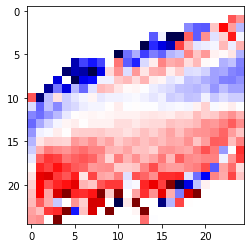

In [235]:
plt.imshow(accel_hist_Z,vmin=-0.005,vmax=0.005,cmap='seismic')

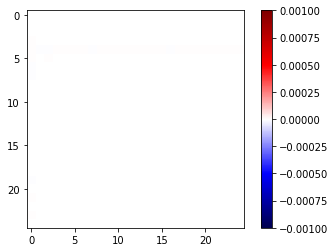

In [278]:
plt.imshow(accel_hist_Y,vmin=-0.001,vmax=0.001,cmap='seismic')
plt.colorbar()

(4, -4)

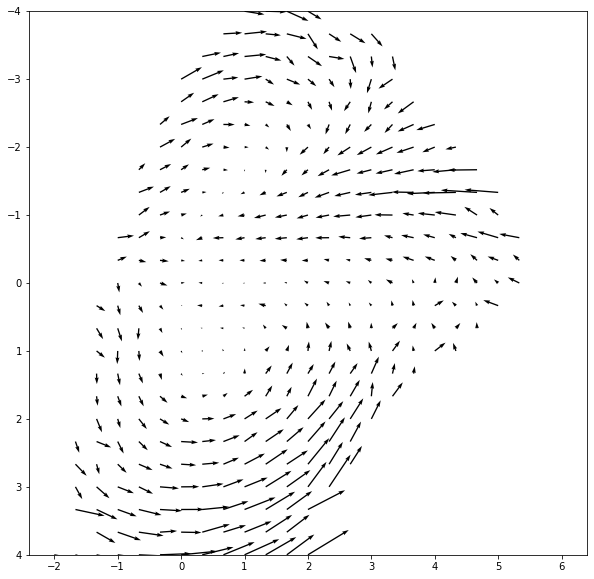

In [229]:
plt.figure(figsize=(10,10))
x,y = np.meshgrid(bins_x, bins_y)
u = accel_hist_Y*10
v = accel_hist_Z*2
v = np.ma.array(v, mask = histcount<100)
plt.quiver(x,y,u,v,scale=.2)
plt.ylim(4,-4)

In [238]:
bins_x

array([-2.        , -1.66666667, -1.33333333, -1.        , -0.66666667,
       -0.33333333,  0.        ,  0.33333333,  0.66666667,  1.        ,
        1.33333333,  1.66666667,  2.        ,  2.33333333,  2.66666667,
        3.        ,  3.33333333,  3.66666667,  4.        ,  4.33333333,
        4.66666667,  5.        ,  5.33333333,  5.66666667,  6.        ])

(4, -4)

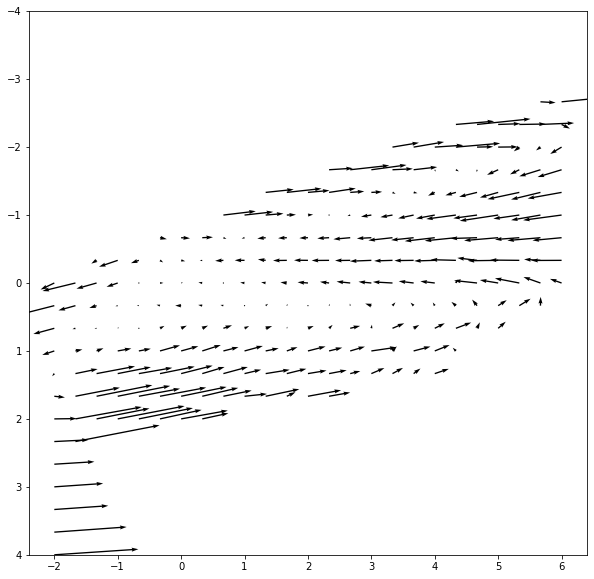

In [240]:
plt.figure(figsize=(10,10))
x,y = np.meshgrid(bins_x, bins_y)
u = accel_hist_Y*10
v = accel_hist_Z*2
v = np.ma.array(v, mask = histcount<100)
plt.quiver(x,y,u,v,scale=.2)
plt.ylim(4,-4)

# 

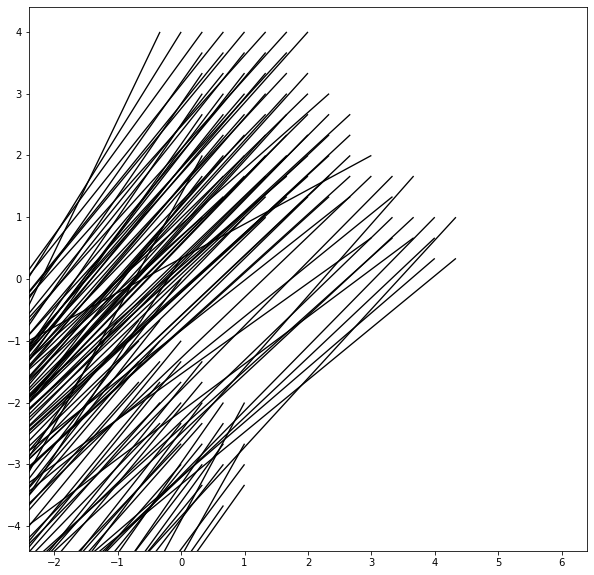

In [616]:
plt.figure(figsize=(10,10))
x,y = np.meshgrid(bins_x, bins_y)
u = np.log(accel_hist_Y*10)
v = np.log(accel_hist_Z*2)
v = np.ma.array(v, mask = histcount<100)
plt.quiver(x,y,u,v,scale=.)
#plt.ylim(4,-4)

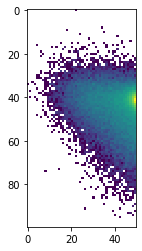

In [216]:
out = np.histogram2d(data[1,:], data[2,:], bins=100)
plt.imshow(np.log(out[0])[:,:50])

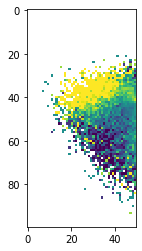

In [222]:
hist = np.log(np.histogram2d(data[1,:], data[2,:], bins=100)[0])
plt.imshow(hist[:,:50]-hist[:,-50:][:,::-1],vmin=-1,vmax=1)# - 

In [286]:
r = R.from_euler('xyz', [0,0,0], degrees=True).as_dcm()
data_r = np.matmul(data.T,r).T

hist = np.log(np.histogram2d(data_r[1,:], data_r[2,:], bins=100)[0])
hist[hist==-inf]=0; hist[hist==inf]=0; hist[hist==np.nan]=0
residual = np.sum((hist[:,:50]-hist[:,-50:][:,::-1])**2)**0.5
residual

43.2160026174187

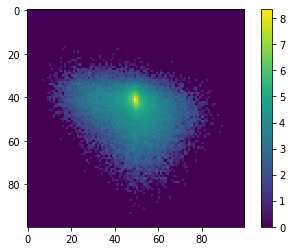

In [384]:
hist = np.log(np.histogram2d(data[1,:], data[2,:], bins=100)[0])
hist[hist==-inf]=0; hist[hist==inf]=0; hist[hist==np.nan]=0
plt.imshow(hist)
plt.colorbar()
#residual = np.sum((hist[:,:50]-hist[:,-50:][:,::-1])**2)**0.5

In [385]:
hist.shape

(100, 100)

In [263]:
np.sum((hist[:,:50]-hist[:,-50:][:,::-1])**2)**0.5

34.21899551819462

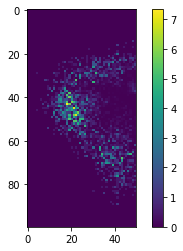

In [261]:
plt.imshow((hist[:,:50]-hist[:,-50:][:,::-1])**2)
plt.colorbar()

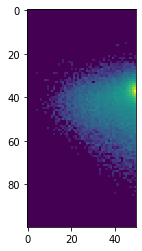

In [256]:
plt.imshow(hist[:,:50])

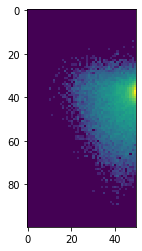

In [257]:
plt.imshow(hist[:,-50:][:,::-1])

In [241]:
np.sum(hist)

-inf

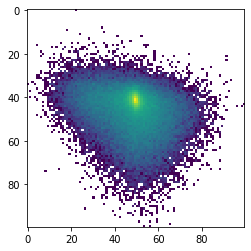

In [235]:
hist = np.log(np.histogram2d(data[1,:], data[2,:], bins=100)[0])
plt.imshow(hist)

In [236]:
hist

array([[-inf, -inf, -inf, ..., -inf, -inf, -inf],
       [-inf, -inf, -inf, ..., -inf, -inf, -inf],
       [-inf, -inf, -inf, ..., -inf, -inf, -inf],
       ...,
       [-inf, -inf, -inf, ..., -inf, -inf, -inf],
       [-inf, -inf, -inf, ..., -inf, -inf, -inf],
       [-inf, -inf, -inf, ..., -inf, -inf, -inf]])

In [210]:
out[0].shape

(100, 100)

8.590845362912914e-08


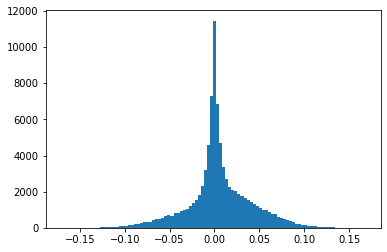

In [161]:
plt.hist(data_r[2,:],bins=100);
print(skew(data_r[2,:]))

In [153]:
np.sum(data_r[0,:]>0)-np.sum(data_r[0,:]<0)

-8041

In [151]:
len(data_r[0,:])

90000

# lets try a manual 3d grid search and visulization of kinematic field

In [13]:
### behavior bins
start_x=-2; end_x=6;
start_y=-4; end_y=4
num_bins_x=25; num_bins_y=25

### Define bins
bins_x, bins_y = np.linspace(start_x,end_x,num_bins_x), np.linspace(start_y,end_y,num_bins_y)

In [14]:
def create_kinematic_field():
    smoothedY = scipy.signal.savgol_filter(data_r[1,:],25,3)
    smoothedZ = scipy.signal.savgol_filter(data_r[2,:],25,3)

    Y_all_std = np.std(smoothedY)
    Z_all_std = np.std(smoothedZ)

     #### Acceleration
    Y_all_accel = np.append(np.diff(smoothedY), 0) #need to add a single value that was removed
    Z_all_accel = np.append(np.diff(smoothedZ), 0) #need to add a single value that was removed

    X_var = smoothedY.copy()
    Y_var = smoothedZ.copy()

    X_var /= Y_all_std
    Y_var /= Z_all_std

    # Assign fictrac values to bin numbers
    idx_x, idx_y = np.digitize(X_var,bins_x), np.digitize(Y_var,bins_y)

    accel_hist_Y = []
    accel_hist_Z = []
    histcount= []
    for i in range(num_bins_x):
        mask_x = (idx_x == i)
        for j in range(num_bins_y):
            mask_y = (idx_y == j)
            mask = mask_x & mask_y
            accel_hist_Y.append(np.mean(Y_all_accel[mask]))
            accel_hist_Z.append(np.mean(Z_all_accel[mask]))
            histcount.append(np.sum(mask))
    accel_hist_Y = np.flip(np.reshape(accel_hist_Y,(num_bins_x, num_bins_y)).T,0)
    accel_hist_Z = np.flip(np.reshape(accel_hist_Z,(num_bins_x, num_bins_y)).T,0)
    histcount = np.flip(np.reshape(histcount,(num_bins_x, num_bins_y)).T,0)
    return accel_hist_Y, accel_hist_Z, histcount

In [35]:
data.shape

(3, 810000)

-25
-20
-15
-10
-5
0
5
10
15
20
25


KeyboardInterrupt: 

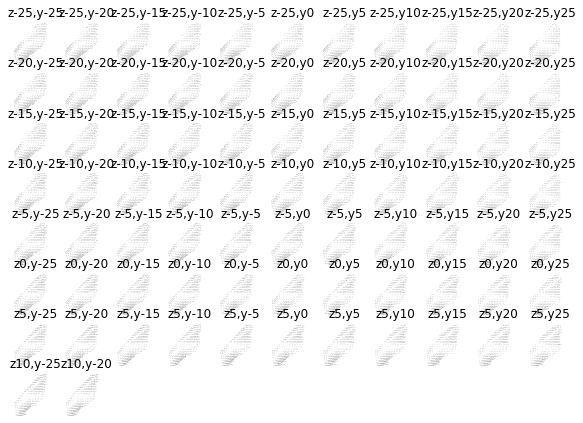

In [93]:
data = np.reshape(np.stack((fictrac['X'], fictrac['Y'], fictrac['Z'])),(3,-1))
x,y = np.meshgrid(bins_x, bins_y)
angle_bins = np.arange(-25,26,5)
num_plots = len(angle_bins)

for x_idx,x_rot in enumerate(angle_bins):
    print(x_rot)
    plt.figure(figsize=(10,10))
    for z_idx,z_rot in enumerate(angle_bins):
        for y_idx,y_rot in enumerate(angle_bins):
            r = R.from_euler('xyz', [x_rot,y_rot,z_rot], degrees=True).as_dcm()
            data_r = np.matmul(data.T,r).T

            accel_hist_Y, accel_hist_Z, histcount = create_kinematic_field()

            y_idx+=1
            plt.subplot(num_plots,num_plots,z_idx*num_plots+y_idx)
            plt.title(F"z{z_rot},y{y_rot}")
            u = accel_hist_Y*10
            v = accel_hist_Z*2
            v = np.ma.array(v, mask = histcount<100)
            plt.quiver(x,y,u,v,scale=.2)
            plt.ylim(4,-4)
            plt.axis('off')

    save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20230126_fictrac_tilt'
    #timestr = time.strftime("%Y%m%d-%H%M%S")
    fname = os.path.join(save_path, f'x_rot {x_rot}')
    plt.savefig(fname,dpi=500,bbox_inches='tight')
    plt.clf()
    plt.close()

In [32]:
os.mkdir('/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20230126_fictrac_tilt')

# BIG RIG

In [241]:
import re
from scipy.ndimage.interpolation import shift


In [192]:
#####################
###  Define Data  ###
#####################

Path = '/oak/stanford/groups/trc/data/Brezovec/VRArena/exps'
#Path = '/scratch/users/brezovec/exps'

Expts = ['exp-20181102-165424',
         'exp-20181102-175232',
         'exp-20181103-184106',
         'exp-20181104-162518',
         'exp-20181105-115608',
         'exp-20181107-181316',
         'exp-20181108-111101',
         'exp-20181108-143044',
         'exp-20181109-084314']

#Expts = ['exp-20181031-190938']

In [193]:
###########################
###  Define Trial Class ###
###########################

class Trial:
    def __init__ (self, dirName):
        print('Importing from: {}'.format(Path))
        self.cam = Cam(os.path.join(dirName, 'cam.txt'))
        self.cnc = Cnc(os.path.join(dirName, 'cnc.txt'))
        self.stimuli = Stimuli(os.path.join(dirName, 'stimuli.txt'), mode='static_stim')
        
class Cam:
    def __init__ (self, fname):
        print(fname)
        self.tvec = np.genfromtxt(fname, delimiter=',',skip_header=1,usecols=(0,))
        self.xvec = np.genfromtxt(fname, delimiter=',',skip_header=1,usecols=(2,))
        self.yvec = np.genfromtxt(fname, delimiter=',',skip_header=1,usecols=(3,))
        self.pvec = np.genfromtxt(fname, delimiter=',',skip_header=1,usecols=(1,), dtype=bool)
        self.avec = np.genfromtxt(fname, delimiter=',',skip_header=1,usecols=(6,))

class Cnc:
    def __init__ (self, fname):
        print(fname)
        self.tvec = np.genfromtxt(fname, delimiter=',',skip_header=1,usecols=(0,))
        self.xvec = np.genfromtxt(fname, delimiter=',',skip_header=1,usecols=(1,))
        self.yvec = np.genfromtxt(fname, delimiter=',',skip_header=1,usecols=(2,))

class Stimuli:
    def __init__ (self, fname, mode):
        print(fname)
        
        if mode == 'static_stim':
            self.dict = stim_parser(fname)
            
        elif mode == 'moving_stim':
            with open(fname) as file:  
                data = file.read() 
            d=data.split('@')
            newStimTimes = [item for item in d if 'NewStim' in item]
            updateStimTimes = [item for item in d if 'UpdateStim' in item]
            StimTimesMessy = newStimTimes + updateStimTimes
            StimTimes = [float(item.split(' ')[0]) for item in StimTimesMessy]
            self.stimtimes = StimTimes

            ratesMessy = [item.split('\n') for item in StimTimesMessy]
            rates_nice = [item for sublist in ratesMessy for item in sublist]
            rates_only = [item for item in rates_nice if 'rate' in item]
            rates = [int(item.split(' ')[3]) for item in rates_only]
            self.rates = rates
            
        else:
            assert('invalid stimuli mode')
        
## For importing files in correct order:
def tryint(s):
    try:
        return int(s)
    except:
        return s

def alphanum_key(s):
    return [tryint(c) for c in re.split('([0-9]+)', s)]

def sort_nicely(x):
    x.sort(key=alphanum_key)
    
def stim_parser(fname):
    with open(fname) as file:  
        data = file.read() 
    d = data.split('\n')
    kv_pair = [item for item in d if ':' in item and '@' not in item]
    stim_dict = {}
    for item in kv_pair:
        key = item.split(':')[0]
        value = item.split(':')[1]
        key = re.sub(" |'|\"|,", "", key)
        value = re.sub(" |'|\"|,", "", value)
        stim_dict[key] = value
    return stim_dict

In [194]:
#####################
###  Import Data  ###
#####################

trials = []        
for expt in Expts:
    dirNames = os.listdir(os.path.join(Path, expt))
    dirNames = [x for x in dirNames if 'trial' in x]
    sort_nicely(dirNames)
    trials.append(([Trial(os.path.join(Path, expt, dirName)) for dirName in dirNames]))
trials = [item for sublist in trials for item in sublist]

Importing from: /oak/stanford/groups/trc/data/Brezovec/VRArena/exps
/oak/stanford/groups/trc/data/Brezovec/VRArena/exps/exp-20181102-165424/trial-1-20181102-170040/cam.txt
/oak/stanford/groups/trc/data/Brezovec/VRArena/exps/exp-20181102-165424/trial-1-20181102-170040/cnc.txt
/oak/stanford/groups/trc/data/Brezovec/VRArena/exps/exp-20181102-165424/trial-1-20181102-170040/stimuli.txt
Importing from: /oak/stanford/groups/trc/data/Brezovec/VRArena/exps
/oak/stanford/groups/trc/data/Brezovec/VRArena/exps/exp-20181102-165424/trial-2-20181102-170055/cam.txt
/oak/stanford/groups/trc/data/Brezovec/VRArena/exps/exp-20181102-165424/trial-2-20181102-170055/cnc.txt
/oak/stanford/groups/trc/data/Brezovec/VRArena/exps/exp-20181102-165424/trial-2-20181102-170055/stimuli.txt
Importing from: /oak/stanford/groups/trc/data/Brezovec/VRArena/exps
/oak/stanford/groups/trc/data/Brezovec/VRArena/exps/exp-20181102-165424/trial-3-20181102-170301/cam.txt
/oak/stanford/groups/trc/data/Brezovec/VRArena/exps/exp-2018

/oak/stanford/groups/trc/data/Brezovec/VRArena/exps/exp-20181102-175232/trial-14-20181102-192609/cnc.txt
/oak/stanford/groups/trc/data/Brezovec/VRArena/exps/exp-20181102-175232/trial-14-20181102-192609/stimuli.txt
Importing from: /oak/stanford/groups/trc/data/Brezovec/VRArena/exps
/oak/stanford/groups/trc/data/Brezovec/VRArena/exps/exp-20181102-175232/trial-15-20181102-192931/cam.txt
/oak/stanford/groups/trc/data/Brezovec/VRArena/exps/exp-20181102-175232/trial-15-20181102-192931/cnc.txt
/oak/stanford/groups/trc/data/Brezovec/VRArena/exps/exp-20181102-175232/trial-15-20181102-192931/stimuli.txt
Importing from: /oak/stanford/groups/trc/data/Brezovec/VRArena/exps
/oak/stanford/groups/trc/data/Brezovec/VRArena/exps/exp-20181102-175232/trial-16-20181102-193118/cam.txt
/oak/stanford/groups/trc/data/Brezovec/VRArena/exps/exp-20181102-175232/trial-16-20181102-193118/cnc.txt
/oak/stanford/groups/trc/data/Brezovec/VRArena/exps/exp-20181102-175232/trial-16-20181102-193118/stimuli.txt
Importing fr

/oak/stanford/groups/trc/data/Brezovec/VRArena/exps/exp-20181103-184106/trial-15-20181103-194919/stimuli.txt
Importing from: /oak/stanford/groups/trc/data/Brezovec/VRArena/exps
/oak/stanford/groups/trc/data/Brezovec/VRArena/exps/exp-20181103-184106/trial-16-20181103-213635/cam.txt
/oak/stanford/groups/trc/data/Brezovec/VRArena/exps/exp-20181103-184106/trial-16-20181103-213635/cnc.txt
/oak/stanford/groups/trc/data/Brezovec/VRArena/exps/exp-20181103-184106/trial-16-20181103-213635/stimuli.txt
Importing from: /oak/stanford/groups/trc/data/Brezovec/VRArena/exps
/oak/stanford/groups/trc/data/Brezovec/VRArena/exps/exp-20181103-184106/trial-17-20181103-223722/cam.txt
/oak/stanford/groups/trc/data/Brezovec/VRArena/exps/exp-20181103-184106/trial-17-20181103-223722/cnc.txt
/oak/stanford/groups/trc/data/Brezovec/VRArena/exps/exp-20181103-184106/trial-17-20181103-223722/stimuli.txt
Importing from: /oak/stanford/groups/trc/data/Brezovec/VRArena/exps
/oak/stanford/groups/trc/data/Brezovec/VRArena/ex

/oak/stanford/groups/trc/data/Brezovec/VRArena/exps/exp-20181105-115608/trial-9-20181105-130753/cnc.txt
/oak/stanford/groups/trc/data/Brezovec/VRArena/exps/exp-20181105-115608/trial-9-20181105-130753/stimuli.txt
Importing from: /oak/stanford/groups/trc/data/Brezovec/VRArena/exps
/oak/stanford/groups/trc/data/Brezovec/VRArena/exps/exp-20181105-115608/trial-10-20181105-131242/cam.txt
/oak/stanford/groups/trc/data/Brezovec/VRArena/exps/exp-20181105-115608/trial-10-20181105-131242/cnc.txt
/oak/stanford/groups/trc/data/Brezovec/VRArena/exps/exp-20181105-115608/trial-10-20181105-131242/stimuli.txt
Importing from: /oak/stanford/groups/trc/data/Brezovec/VRArena/exps
/oak/stanford/groups/trc/data/Brezovec/VRArena/exps/exp-20181105-115608/trial-11-20181105-131734/cam.txt
/oak/stanford/groups/trc/data/Brezovec/VRArena/exps/exp-20181105-115608/trial-11-20181105-131734/cnc.txt
/oak/stanford/groups/trc/data/Brezovec/VRArena/exps/exp-20181105-115608/trial-11-20181105-131734/stimuli.txt
Importing from

/oak/stanford/groups/trc/data/Brezovec/VRArena/exps/exp-20181105-115608/trial-31-20181105-152448/cnc.txt
/oak/stanford/groups/trc/data/Brezovec/VRArena/exps/exp-20181105-115608/trial-31-20181105-152448/stimuli.txt
Importing from: /oak/stanford/groups/trc/data/Brezovec/VRArena/exps
/oak/stanford/groups/trc/data/Brezovec/VRArena/exps/exp-20181107-181316/trial-1-20181107-181948/cam.txt
/oak/stanford/groups/trc/data/Brezovec/VRArena/exps/exp-20181107-181316/trial-1-20181107-181948/cnc.txt
/oak/stanford/groups/trc/data/Brezovec/VRArena/exps/exp-20181107-181316/trial-1-20181107-181948/stimuli.txt
Importing from: /oak/stanford/groups/trc/data/Brezovec/VRArena/exps
/oak/stanford/groups/trc/data/Brezovec/VRArena/exps/exp-20181107-181316/trial-2-20181107-182044/cam.txt
/oak/stanford/groups/trc/data/Brezovec/VRArena/exps/exp-20181107-181316/trial-2-20181107-182044/cnc.txt
/oak/stanford/groups/trc/data/Brezovec/VRArena/exps/exp-20181107-181316/trial-2-20181107-182044/stimuli.txt
Importing from: /o

/oak/stanford/groups/trc/data/Brezovec/VRArena/exps/exp-20181107-181316/trial-21-20181107-191239/stimuli.txt
Importing from: /oak/stanford/groups/trc/data/Brezovec/VRArena/exps
/oak/stanford/groups/trc/data/Brezovec/VRArena/exps/exp-20181107-181316/trial-22-20181107-191545/cam.txt
/oak/stanford/groups/trc/data/Brezovec/VRArena/exps/exp-20181107-181316/trial-22-20181107-191545/cnc.txt
/oak/stanford/groups/trc/data/Brezovec/VRArena/exps/exp-20181107-181316/trial-22-20181107-191545/stimuli.txt
Importing from: /oak/stanford/groups/trc/data/Brezovec/VRArena/exps
/oak/stanford/groups/trc/data/Brezovec/VRArena/exps/exp-20181107-181316/trial-23-20181107-192031/cam.txt
/oak/stanford/groups/trc/data/Brezovec/VRArena/exps/exp-20181107-181316/trial-23-20181107-192031/cnc.txt
/oak/stanford/groups/trc/data/Brezovec/VRArena/exps/exp-20181107-181316/trial-23-20181107-192031/stimuli.txt
Importing from: /oak/stanford/groups/trc/data/Brezovec/VRArena/exps
/oak/stanford/groups/trc/data/Brezovec/VRArena/ex

/oak/stanford/groups/trc/data/Brezovec/VRArena/exps/exp-20181108-111101/trial-19-20181108-120822/cnc.txt
/oak/stanford/groups/trc/data/Brezovec/VRArena/exps/exp-20181108-111101/trial-19-20181108-120822/stimuli.txt
Importing from: /oak/stanford/groups/trc/data/Brezovec/VRArena/exps
/oak/stanford/groups/trc/data/Brezovec/VRArena/exps/exp-20181108-111101/trial-20-20181108-121054/cam.txt
/oak/stanford/groups/trc/data/Brezovec/VRArena/exps/exp-20181108-111101/trial-20-20181108-121054/cnc.txt
/oak/stanford/groups/trc/data/Brezovec/VRArena/exps/exp-20181108-111101/trial-20-20181108-121054/stimuli.txt
Importing from: /oak/stanford/groups/trc/data/Brezovec/VRArena/exps
/oak/stanford/groups/trc/data/Brezovec/VRArena/exps/exp-20181108-111101/trial-21-20181108-121508/cam.txt
/oak/stanford/groups/trc/data/Brezovec/VRArena/exps/exp-20181108-111101/trial-21-20181108-121508/cnc.txt
/oak/stanford/groups/trc/data/Brezovec/VRArena/exps/exp-20181108-111101/trial-21-20181108-121508/stimuli.txt
Importing fr

Importing from: /oak/stanford/groups/trc/data/Brezovec/VRArena/exps
/oak/stanford/groups/trc/data/Brezovec/VRArena/exps/exp-20181108-143044/trial-14-20181108-154747/cam.txt
/oak/stanford/groups/trc/data/Brezovec/VRArena/exps/exp-20181108-143044/trial-14-20181108-154747/cnc.txt
/oak/stanford/groups/trc/data/Brezovec/VRArena/exps/exp-20181108-143044/trial-14-20181108-154747/stimuli.txt
Importing from: /oak/stanford/groups/trc/data/Brezovec/VRArena/exps
/oak/stanford/groups/trc/data/Brezovec/VRArena/exps/exp-20181108-143044/trial-15-20181108-154904/cam.txt
/oak/stanford/groups/trc/data/Brezovec/VRArena/exps/exp-20181108-143044/trial-15-20181108-154904/cnc.txt
/oak/stanford/groups/trc/data/Brezovec/VRArena/exps/exp-20181108-143044/trial-15-20181108-154904/stimuli.txt
Importing from: /oak/stanford/groups/trc/data/Brezovec/VRArena/exps
/oak/stanford/groups/trc/data/Brezovec/VRArena/exps/exp-20181108-143044/trial-16-20181108-155314/cam.txt
/oak/stanford/groups/trc/data/Brezovec/VRArena/exps/e

/oak/stanford/groups/trc/data/Brezovec/VRArena/exps/exp-20181109-084314/trial-4-20181109-090724/stimuli.txt
Importing from: /oak/stanford/groups/trc/data/Brezovec/VRArena/exps
/oak/stanford/groups/trc/data/Brezovec/VRArena/exps/exp-20181109-084314/trial-5-20181109-090820/cam.txt
/oak/stanford/groups/trc/data/Brezovec/VRArena/exps/exp-20181109-084314/trial-5-20181109-090820/cnc.txt
/oak/stanford/groups/trc/data/Brezovec/VRArena/exps/exp-20181109-084314/trial-5-20181109-090820/stimuli.txt
Importing from: /oak/stanford/groups/trc/data/Brezovec/VRArena/exps
/oak/stanford/groups/trc/data/Brezovec/VRArena/exps/exp-20181109-084314/trial-6-20181109-091659/cam.txt
/oak/stanford/groups/trc/data/Brezovec/VRArena/exps/exp-20181109-084314/trial-6-20181109-091659/cnc.txt
/oak/stanford/groups/trc/data/Brezovec/VRArena/exps/exp-20181109-084314/trial-6-20181109-091659/stimuli.txt
Importing from: /oak/stanford/groups/trc/data/Brezovec/VRArena/exps
/oak/stanford/groups/trc/data/Brezovec/VRArena/exps/exp-

In [195]:
########################
### Define Fly Class ###
########################

class Fly:
    def __init__ (self,trial,time_res=0.01,sigma=0):
        mode = 'static_stim'
        if np.any(trial.cam.pvec):
            # Get cam data (only time points where pvec is true, aka fly is present)
            camt = trial.cam.tvec[trial.cam.pvec]
            #Interpolate
            cama = interp1d(camt, trial.cam.avec[trial.cam.pvec],kind='nearest')
            camx = interp1d(camt, trial.cam.xvec[trial.cam.pvec])
            camy = interp1d(camt, trial.cam.yvec[trial.cam.pvec])
            # Get cnc data
            cncx = interp1d(trial.cnc.tvec, trial.cnc.xvec)
            cncy = interp1d(trial.cnc.tvec, trial.cnc.yvec)
            tmin = max(camt[0], trial.cnc.tvec[0])
            tmax = min(camt[-1], trial.cnc.tvec[-1])
            # Pull from interpolated data at chosen time resolution, and add camera and cnc positions
            self.t = np.arange(tmin, tmax, time_res)
            self.x = camx(self.t) + cncx(self.t)
            self.y = camy(self.t) + cncy(self.t)
            self.a = cama(self.t)
            # Unwrap angles and rotate
            self.angleUnwrapper()
            #self.a=angleChangeOrigin(self.a)
            self.a = 90-self.a #rotate angles 90deg to change ellipse fitting defined angles
            self.a = -self.a #flip angle horizontally due to camera flip
            # Smooth if asked to
            if sigma is not 0:
                self.x = scipy.ndimage.filters.gaussian_filter1d(self.x,sigma)
                self.y = scipy.ndimage.filters.gaussian_filter1d(self.y,sigma)
                self.a = scipy.ndimage.filters.gaussian_filter1d(self.a,sigma)
            self.tvid = self.t - camt[0] #for video debugging
            self.velocity()
            x_covered = np.sum(np.abs(np.diff(self.x)))
            y_covered = np.sum(np.abs(np.diff(self.y)))
            self.dist_covered = x_covered + y_covered
            self.duration = self.t[-1]-self.t[0]
            self.a_covered = np.sum(np.abs(np.diff(self.a)))
            
            if mode == 'static_stim':
                self.stimdict = trial.stimuli.dict

            elif mode == 'moving_stim':
                self.stimtimes = trial.stimuli.stimtimes
                self.rates = trial.stimuli.rates
            
        else:
            self.t = None
            self.x = None
            self.y = None
            self.a = None
            self.v = None
            self.tvid = None    
    def angleUnwrapper(self):
        jumpThresh=150
        angles=[]
        angle_offset=0
        for k, angle in enumerate(self.a):
            if k == 0:
                angles.append(angle)
                continue
            angle += angle_offset
            if angles[-1]-angle > jumpThresh:
                angle_offset += 180
                angle += 180
            elif angle-angles[-1] > jumpThresh:
                angle_offset -= 180
                angle -= 180
            angles.append(angle)
        self.a = np.array(angles)
    def velocity(self):
        x1 = self.x
        y1 = self.y
        a1 = self.a
        x2 = shift(x1,-1,cval=np.NaN)
        y2 = shift(y1,-1,cval=np.NaN)
        a2 = shift(a1,-1,cval=np.NaN)
        # Calculate velocity
        dist = (((x2-x1)**2)+((y2-y1)**2))**0.5
        self.v = dist[:-2]
        #
        vel_x = x2-x1
        self.vx = vel_x[:-2]
        vel_y = y2-y1
        self.vy = vel_y[:-2]
        # Calculate angle of velocity
        #velocity_angle = np.rad2deg(np.arctan2((y2-y1),(x2-x1)))
        #fly_angle = self.a%(360)
        #angle_difference = velocity_angle-fly_angle
        #forward_component = (np.cos(angle_difference*np.pi/180))
        #self.vf = forward_component[:-2]
        #self.va = velocity_angle[:-2]
        # Calculate angular velocity
        angular_velocity = a2-a1
        self.av = angular_velocity[:-2]

class FlyArrow:
    def __init__ (self,fly,scale,flip=False):
        if np.any(fly.x):
            if flip is True:
                fly.a = fly.a + 180
            self.x1 = fly.x-np.cos(fly.a*np.pi/180)*scale
            self.x2 = fly.x+np.cos(fly.a*np.pi/180)*scale
            self.y1 = fly.y-np.sin(fly.a*np.pi/180)*scale
            self.y2 = fly.y+np.sin(fly.a*np.pi/180)*scale
        else:
            self.x1 = None
            self.x2 = None
            self.y1 = None
            self.y2 = None            

# def angleChangeOrigin(a):
#     if a[0] <= 90:
#         a=90-a+90
#     if a[0] >90:
#         a=270-a+90
#     return a            
            
# def smooth(x,sigma):
#     x = scipy.ndimage.filters.gaussian_filter1d(x,sigma)
#     return x

In [196]:
#################################################
### Create fly class and pull from trial data ###
#################################################

class Fly:
    def __init__ (self,trial,time_res=0.01,sigma=0):
        if np.any(trial.cam.pvec):
            # Get cam data (only time points where pvec is true, aka fly is present)
            camt = trial.cam.tvec
            #Interpolate
            cama = interp1d(camt, trial.cam.avec,kind='nearest')
            camx = interp1d(camt, trial.cam.xvec)
            camy = interp1d(camt, trial.cam.yvec)
            # Get cnc data
            cncx = interp1d(trial.cnc.tvec, trial.cnc.xvec)
            cncy = interp1d(trial.cnc.tvec, trial.cnc.yvec)
            tmin = max(camt[0], trial.cnc.tvec[0])
            tmax = min(camt[-1], trial.cnc.tvec[-1])
            # Pull from interpolated data at chosen time resolution, and add camera and cnc positions
            self.t = np.arange(tmin, tmax, time_res)
            self.x = camx(self.t) + cncx(self.t)
            self.y = camy(self.t) + cncy(self.t)
            self.a = cama(self.t)
            # Unwrap angles and rotate
            self.angleUnwrapper()
            #self.a=angleChangeOrigin(self.a)
            self.a = 90-self.a #rotate angles 90deg to change ellipse fitting defined angles
            self.a = -self.a #flip angle horizontally due to camera flip
            # Smooth if asked to
            if sigma is not 0:
                self.x = scipy.ndimage.filters.gaussian_filter1d(self.x,sigma)
                self.y = scipy.ndimage.filters.gaussian_filter1d(self.y,sigma)
                self.a = scipy.ndimage.filters.gaussian_filter1d(self.a,sigma)
            self.tvid = self.t - camt[0] #for video debugging
            self.velocity()
        else:
            self.t = None
            self.x = None
            self.y = None
            self.a = None
            self.v = None
            self.tvid = None    
    def angleUnwrapper(self):
        jumpThresh=150
        angles=[]
        angle_offset=0
        for k, angle in enumerate(self.a):
            if k == 0:
                angles.append(angle)
                continue
            angle += angle_offset
            if angles[-1]-angle > jumpThresh:
                angle_offset += 180
                angle += 180
            elif angle-angles[-1] > jumpThresh:
                angle_offset -= 180
                angle -= 180
            angles.append(angle)
        self.a = np.array(angles)
    def velocity(self):
        x1 = self.x
        y1 = self.y
        a1 = self.a
        x2 = shift(x1,-1,cval=np.NaN)
        y2 = shift(y1,-1,cval=np.NaN)
        a2 = shift(a1,-1,cval=np.NaN)
        # Calculate velocity
        dist = (((x2-x1)**2)+((y2-y1)**2))**0.5
        self.v = dist[:-2]
        #
        vel_x = x2-x1
        self.vx = vel_x[:-2]
        vel_y = y2-y1
        self.vy = vel_y[:-2]
        # Calculate angle of velocity
        velocity_angle = np.rad2deg(np.arctan2((y2-y1),(x2-x1)))
        #fly_angle = self.a%(360)
        #angle_difference = velocity_angle-fly_angle
        #forward_component = (np.cos(angle_difference*np.pi/180))
        #self.vf = forward_component[:-2]
        self.va = velocity_angle[:-2]
        # Calculate angular velocity
        angular_velocity = a2-a1
        self.av = angular_velocity[:-2]

class FlyArrow:
    def __init__ (self,fly,scale,flip=False):
        if np.any(fly.x):
            if flip is True:
                fly.a = fly.a + 180
            self.x1 = fly.x-np.cos(fly.a*np.pi/180)*scale
            self.x2 = fly.x+np.cos(fly.a*np.pi/180)*scale
            self.y1 = fly.y-np.sin(fly.a*np.pi/180)*scale
            self.y2 = fly.y+np.sin(fly.a*np.pi/180)*scale
        else:
            self.x1 = None
            self.x2 = None
            self.y1 = None
            self.y2 = None            

# def angleChangeOrigin(a):
#     if a[0] <= 90:
#         a=90-a+90
#     if a[0] >90:
#         a=270-a+90
#     return a            
            
# def smooth(x,sigma):
#     x = scipy.ndimage.filters.gaussian_filter1d(x,sigma)
#     return x

In [242]:
###################
### BUILD FLIES ###
###################

flies = [Fly(trial,sigma=10) for trial in trials]

In [256]:
fwd = []
rot = []
for i in range(len(flies)):
    fwd.extend(flies[i].v)
    rot.extend(flies[i].av)

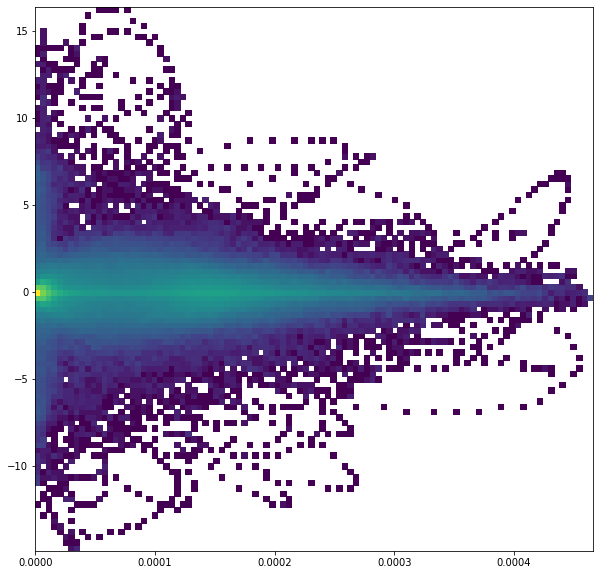

In [263]:
plt.figure(figsize=(10,10))
plt.hist2d(fwd,rot,bins=100,norm=LogNorm());

In [279]:
smoothedY = scipy.signal.savgol_filter(fwd,25,3)
smoothedZ = scipy.signal.savgol_filter(rot,25,3)

Y_all_std = np.std(smoothedY)
Z_all_std = np.std(smoothedZ)

In [280]:
 #### Acceleration
Y_all_accel = np.append(np.diff(smoothedY), 0) #need to add a single value that was removed
Z_all_accel = np.append(np.diff(smoothedZ), 0) #need to add a single value that was removed

In [281]:
X_var = smoothedY.copy()
Y_var = smoothedZ.copy()

X_var /= Y_all_std
Y_var /= Z_all_std

### behavior bins
start_x=-2; end_x=6;
start_y=-4; end_y=4
num_bins_x=25; num_bins_y=25

### Define bins
bins_x, bins_y = np.linspace(start_x,end_x,num_bins_x), np.linspace(start_y,end_y,num_bins_y)

# Assign fictrac values to bin numbers
idx_x, idx_y = np.digitize(X_var,bins_x), np.digitize(Y_var,bins_y)

In [282]:
num_bins_x=25; num_bins_y=25

accel_hist_Y = []
accel_hist_Z = []
histcount= []
for i in range(num_bins_x):
    mask_x = (idx_x == i)
    for j in range(num_bins_y):
        mask_y = (idx_y == j)
        mask = mask_x & mask_y
        accel_hist_Y.append(np.mean(Y_all_accel[mask]))
        accel_hist_Z.append(np.mean(Z_all_accel[mask]))
        histcount.append(np.sum(mask))
accel_hist_Y = np.flip(np.reshape(accel_hist_Y,(num_bins_x, num_bins_y)).T,0)
accel_hist_Z = np.flip(np.reshape(accel_hist_Z,(num_bins_x, num_bins_y)).T,0)
histcount = np.flip(np.reshape(histcount,(num_bins_x, num_bins_y)).T,0)

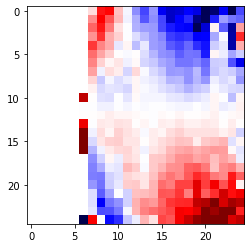

In [285]:
plt.imshow(accel_hist_Z,vmin=-0.05,vmax=0.05,cmap='seismic')

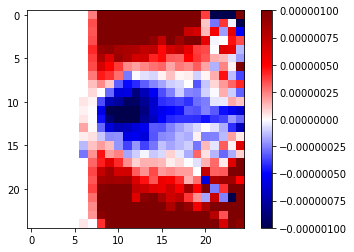

In [288]:
plt.imshow(accel_hist_Y,vmin=-0.000001,vmax=0.000001,cmap='seismic')
plt.colorbar()

(4, -4)

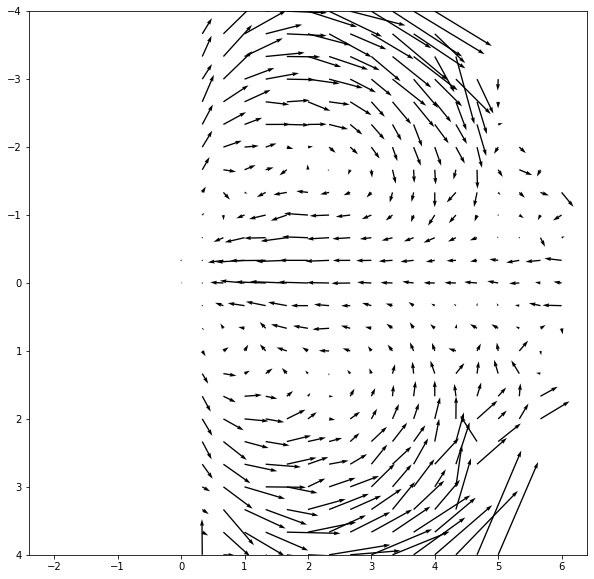

In [295]:
plt.figure(figsize=(10,10))
x,y = np.meshgrid(bins_x, bins_y)
u = accel_hist_Y*10000
v = accel_hist_Z*0.5
v = np.ma.array(v, mask = histcount<100)
plt.quiver(x,y,u,v,scale=.2)
plt.ylim(4,-4)

array([0., 0., 0., ..., 0., 0., 0.])

In [266]:
data.shape

(3, 810000)

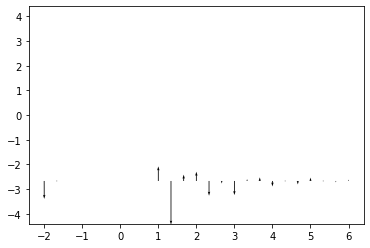

In [277]:
data_r = np.stack((np.zeros(len(fwd)), np.asarray(fwd), np.asarray(rot)))
data_r = np.reshape(data_r,(3,-1))

### behavior bins
start_x=0; end_x=0.0004;
start_y=-10; end_y=10
num_bins_x=25; num_bins_y=25

### Define bins
bins_x, bins_y = np.linspace(start_x,end_x,num_bins_x), np.linspace(start_y,end_y,num_bins_y)

accel_hist_Y, accel_hist_Z, histcount = create_kinematic_field()

u = accel_hist_Y*1000
v = accel_hist_Z*200
v = np.ma.array(v, mask = histcount<100)
plt.quiver(x,y,u,v,scale=.2)

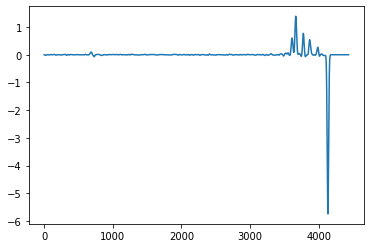

In [254]:
plt.plot(flies[4].av)

In [243]:
################################################
### Assign fly types based on visual stimuli ###
################################################

for fly in flies:
    if fly.stimdict['name'] == 'ConstantBackground' and fly.stimdict['background'] == '0.0':
        fly.type = 'dark'
    elif fly.stimdict['name'] == 'ConstantBackground' and fly.stimdict['background'] == '0.5':
        fly.type = 'grey'
    elif fly.stimdict['name'] == 'ConstantBackground' and fly.stimdict['background'] == '1.0':
        fly.type = 'bright'
    elif fly.stimdict['name'] == 'SineGrating' and fly.stimdict['angle'] == '0':
        fly.type = 'vertical'
    elif fly.stimdict['name'] == 'SineGrating' and fly.stimdict['angle'] == '90':
        fly.type = 'horizontal'
    elif fly.stimdict['name'] == 'RandomGrid':
        fly.type = 'checker'
    else:
        print('Did not assign type to fly with stimuli name: {}'.format(fly.stimdict['name']))

AttributeError: 'Fly' object has no attribute 'stimdict'

In [ ]:
#############################
### Plot Angular Velocity ###
#############################

fig = plt.figure(figsize=(10, 10))
bins = np.ndarray.tolist(np.arange(-500,500,10))
count=0
for i, type in enumerate(['dark']):
    for k, fly in enumerate(flies):
        if fly.x is not None and fly.y is not None:
            if fly.type == type:
                count +=1
                vector = fly.av * 100 # now in deg per sec
                weights = np.ones_like(vector)/float(len(vector))
                binned,throwaway,throwaway2=plt.hist(vector,bins,weights=weights,label = str(i),stacked=True, linewidth=3,histtype = 'step')

plt.xlim(-500,500)
plt.ylim(0,.5)
plt.xlabel('Velocity (deg/sec)')
plt.ylabel('Frequency, Normalized')
plt.show()